In [ ]:
import os
import sys 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler
from pycirclize import Circos, config
from pycirclize.parser import Gff
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from textwrap import fill

%load_ext autoreload
%autoreload 2

rawdata_path = os.path.abspath(os.path.join('../data/raw/'))
sys.path.insert(0, rawdata_path)


In [ ]:
pathways_path = os.path.join(rawdata_path, r"Circus 25 genes_Pathways_2.xlsx")
upregulatedpathways = pd.read_excel(pathways_path)
print(upregulatedpathways)  

upregulatedpathways['genes'] = upregulatedpathways['genes'].apply(lambda x: [gene for gene in x.split('/')])
upregulatedpathways


In [ ]:
genes = list(set(gene for genes_list in upregulatedpathways['genes'] for gene in genes_list))
pathways = upregulatedpathways['pathway'].unique()

# Original df
circos_data = pd.DataFrame(0, index=genes, columns=pathways)

for _, row in upregulatedpathways.iterrows():
    for gene in row['genes']:
        circos_data.at[gene, row['pathway']] = 1

circos_data

In [ ]:
data = ["HMGB1", "RHOA", "HMOX1", "RGCC", "EDN1", "CYP1B1", "ATP5F1B", "MIA3",
        "HLA-A", "LGMN", "F3", "CFL1", "ROBO1", "CALR", "SERPINE1", "WDR1",
        "TGFBR1", "ROCK2", "HIF1A", "PRKCA", "PPARG", "SNAI2", "STAT1", "ECM1", "TGFB1"]
pathways = ["regulation of angiogenesis", "regulation of vasculature development", 
            "endothelial cell migration", "HIF-1 signaling pathway", "tissue migration", 
            "actin filament organization", "regulation of blood vessel endothelial cell migration", 
            "epithelial to mesenchymal transition", "positive regulation of stress fiber assembly", 
            "mitotic cytokinesis", "Rho protein signal transduction", "leukocyte migration", 
            "Dectin-1 mediated noncanonical NF-kB signaling", 
            "TGF-beta receptor signaling in EMT", 
            "receptor signaling pathway via JAK-STAT", "interferon-mediated signaling pathway", 
            "transforming growth factor beta receptor signaling pathway", 
            "tumor necrosis factor-mediated signaling pathway"]

circos_filtered = circos_data[circos_data.index.isin(data)]
circos_filtered = circos_filtered.loc[:, (circos_filtered != 0).any(axis=0)]
circos_filtered = circos_filtered.loc[:, circos_filtered.columns.intersection(pathways)]
circos_filtered = circos_filtered[circos_filtered.any(axis=1)]

noninteractinggenes = list(set(data)- set(circos_filtered.index))
print("These genes are not in any of the listed pathways: " + str(noninteractinggenes))
noninteractingpathways = list(set(pathways) - set(circos_filtered.columns))
print("These pathways have none of the listed genes: " + str(noninteractingpathways))

# Sort the genes by the length of their names, so that they are less likely to overlap in the circos plot
length = lambda x: len(x) 
l = np.vectorize(length)
circos_filtered.sort_index(axis=0, key=l, inplace=True, ascending=False)
circos_filtered.head()

In [27]:
def capitalize(input):
    return input[0].upper()+input[1:]

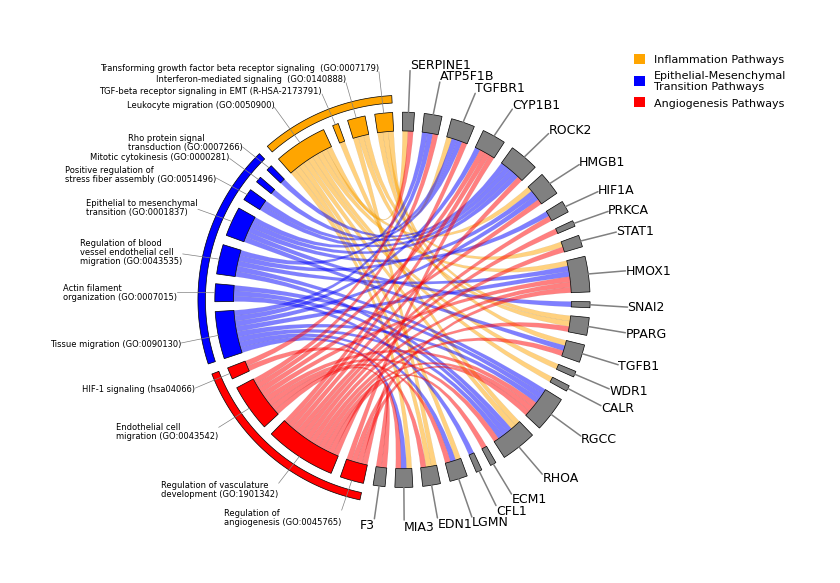

In [ ]:
colourmap = {"Angiogenesis":"red", "Epithelial-Mesenchymal-Transition":"blue", "Inflammation":"orange"}
pathwaycolourgrouping = dict(zip(upregulatedpathways["pathway"], upregulatedpathways["category"].map(colourmap)))


row_names = circos_filtered.index
col_names = circos_filtered.columns
matrix_data = circos_filtered
matrix_df = pd.DataFrame(matrix_data, index=row_names, columns=col_names)

link_cmap = []
for gene in circos_filtered.index:
    for pathway in circos_filtered.columns:
        if circos_filtered.loc[gene, pathway] == 1:
            link_cmap.append((gene, pathway, pathwaycolourgrouping[pathway]))
            
pathwaygroups = {}
for pathway in circos_filtered.columns:
    cat = upregulatedpathways[upregulatedpathways["pathway"]==pathway]["category"].values[0]
    if cat not in pathwaygroups:
        pathwaygroups[cat] = [pathway]
    else:
        pathwaygroups[cat].append(pathway)

angiogenesisgroup, EMTgroup, inflammationgroup = pathwaygroups.values()

groupspaces = [len(g) for g in pathwaygroups.values()]



# Initialize Circos instance for chord diagram plot
circos = Circos.chord_diagram(
    matrix_df,
    space=3,
    cmap= pathwaycolourgrouping,
    label_kws=dict(size=10, visible=False),
    link_cmap = link_cmap,
    r_lim=(90, 100)   
    
)
#Plot annotations
for track, sector in zip(circos.tracks, circos.sectors):
    if sector.name in row_names: # If the track is a gene
        start, end = track.start, track.end
        label_pos = (start + end) / 2
        label = capitalize(sector.name)
        track.annotate(label_pos, label, label_size=9, 
                       min_r = max(track.r_lim),
                       max_r = max(track.r_lim)+20, 
                       shorten = 40, 
                       line_kws = dict(lw=1.1),
                       text_kws = dict(linespacing = 2)
                      )

    else: # If the track is a pathway        
        category = upregulatedpathways[upregulatedpathways["pathway"]==sector.name]["category"].values[0]
        
        if category == "Inflammation": # If the pathway is in the (orange) inflammation group
            start, end = track.start, track.end
            label_pos = (start + end) / 2
            path = capitalize(sector.name.replace("pathway", ""))# Make the orange annotations longer: NO fill
            GOid = upregulatedpathways[upregulatedpathways["pathway"] == sector.name]["GOid"].values[0]
            label = f"{path} ({GOid})"

            track.annotate(label_pos, label, label_size=6, # Add the wrap-around
                           min_r = max(track.r_lim),
                           max_r = max(track.r_lim) + (20 if (sector.name == "TGF-beta receptor signaling in EMT") else
                                                       22 if (sector.name == "interferon-mediated signaling pathway") else 
                                                       25), 
                                   # Make the orange annotations farther out
                           shorten = float('inf'), # don't shorten it
                           text_kws = dict(linespacing = 1, multialignment = "left")
                          ) 

        else: # For the angiogenesis (red) and EMT (blue) groups
            start, end = track.start, track.end
            label_pos = (start + end) / 2
            path = fill(capitalize(sector.name.replace("pathway", "")), 25)
            GOid = upregulatedpathways[upregulatedpathways["pathway"] == sector.name]["GOid"].values[0]
            label = f"{path} ({GOid})"

            track.annotate(label_pos, label, label_size=6, # Add the wrap-around
               min_r = max(track.r_lim),
               max_r = max(track.r_lim)+20, 
               shorten = float('inf'), # Don't shorten it
               text_kws = dict(linespacing = 1, multialignment = "left")
              ) 

# Enable annotation text adjustment (Default)
config.ann_adjust.enable = True

# Calculate appropriate group between/within spaces
spaces = calc_group_spaces([4, 5, 5], space_bw_group=2)

# Plot group sectors range
colours = ["red", "blue", "orange"]
for idx, group in enumerate((angiogenesisgroup, EMTgroup, inflammationgroup), 1):
    group_deg_lim = circos.get_group_sectors_deg_lim(group)
    circos.rect(r_lim=(105, 109), deg_lim=group_deg_lim, fc= colours[idx-1], ec="black", lw=0.5)
    group_center_deg = sum(group_deg_lim) / 2

fig = circos.plotfig()

# Add legend
handles = [
    Patch(color="orange", label="Inflammation Pathways"),
    Patch(color="blue", label=fill("Epithelial-Mesenchymal Transition Pathways", 30)),
    Patch(color="red", label="Angiogenesis Pathways"),
]


_ = circos.ax.legend(handles=handles, bbox_to_anchor=(1.5, 1.15), loc="upper right", fontsize=8)

fig.savefig(
    fname = r"circos_plot_1003.png",
    dpi = 1000,
    pad_inches = 0.5
)